## learning-AI : deep learning application (61357002)
### assignment : diabetes classification using CNN with transfer learning (DL)

**당뇨 데이터를 1D-CNN 하여 classification (split_sequence 사용 및 transfer learning)**

<br>

- **임규연 (lky473736)**
- 2024.09.26.에 문서 작성
- **dataset** : https://github.com/plotly/datasets/blob/master/diabetes.csv
- **kaggle** : https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data
- **data abstract** : This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

------

## <span id='dl'><mark>DL</mark></span>
<br>

- **Reference**
    - https://github.com/lky473736/learning-AI/blob/main/class/assignment/topic3/LSTM(transfer-learning)_classification_HAR_DSADS(assignment).ipynb
    - https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb
    - https://github.com/MyungKyuYi/AI-class/blob/main/fixed_code.ipynb

<br>
    
deep learning으로 diabetes를 classification한다. **1D-CNN을 통하여 classification한다.** split_sequence()를 하여 CNN을 진행할 때 주의할 점은 아래와 같다.

- `(주의할 점 1) 적절한 timestep`
    - **앞으로는 EDA를 하기 전, uci dataset에 대한 설명을 먼저 정독한 후에 진행하자.**
    - 만약 특정 시계열 데이터셋이 있다고 가정할 때, 그에 대한 샘플링 속도는 50Hz라고 한다면, 이는 1초 동안 50개의 데이터를 수집했다는 의미이다. -> **따라서 1초 간의 활동을 포착하려고 할 때 타임스텝은 50으로 설정해야 하는 것이 일반적이다.**
    
- `(주의할 점 2) label counting의 불균형을 확인할 것`
    - **부족한 label에 해당되는 records의 수를 늘린다. (oversampling)**
    - 반대로, 너무 많은 label에 해당되는 records의 수는 감소한다. (undersampling)
    
- `(주의할 점 3) 많은 양의 records`
    - 파일에 들어있는 records 수가 많으면 시간 측면에서도 오래 걸리며, 원할한 학습이 이루어지지 않을 수 있다.
    - 따라서 데이터셋 중에서도, label이 고르고 각 feature가 정규분포 모양을 잘 따르고 있는 데이터셋을 선정하여 학습하는 것이 중요하다.

<br>

이번 문서에서는, transfer learning을 진행하여 accuracy를 증가해보겠다. 따라서 아래와 같은 목차로 진행한다.

- **1. 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성**
- **2. modeling 수행**
- **3. transfer learning - pre-trained model, fine-tuning**


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

2024-09-26 10:43:50.850893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


-----------



### 1. 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- 순환 데이터로 구성하기 위하여 split_sequence를 빈도 기준으로 한다.

In [3]:
# 파일 읽기

df = pd.read_csv('../../data/diabetes.csv')

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Pregnancies의 데이터 타입 :  int64
Glucose의 데이터 타입 :  int64
BloodPressure의 데이터 타입 :  int64
SkinThickness의 데이터 타입 :  int64
Insulin의 데이터 타입 :  int64
BMI의 데이터 타입 :  float64
DiabetesPedigreeFunction의 데이터 타입 :  float64
Age의 데이터 타입 :  int64
Outcome의 데이터 타입 :  int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# 결측치 확인 및 dropna로 결측치에 해당되는 record 삭제

print (df.isnull().sum())
df = df.dropna()
print ('\n', df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


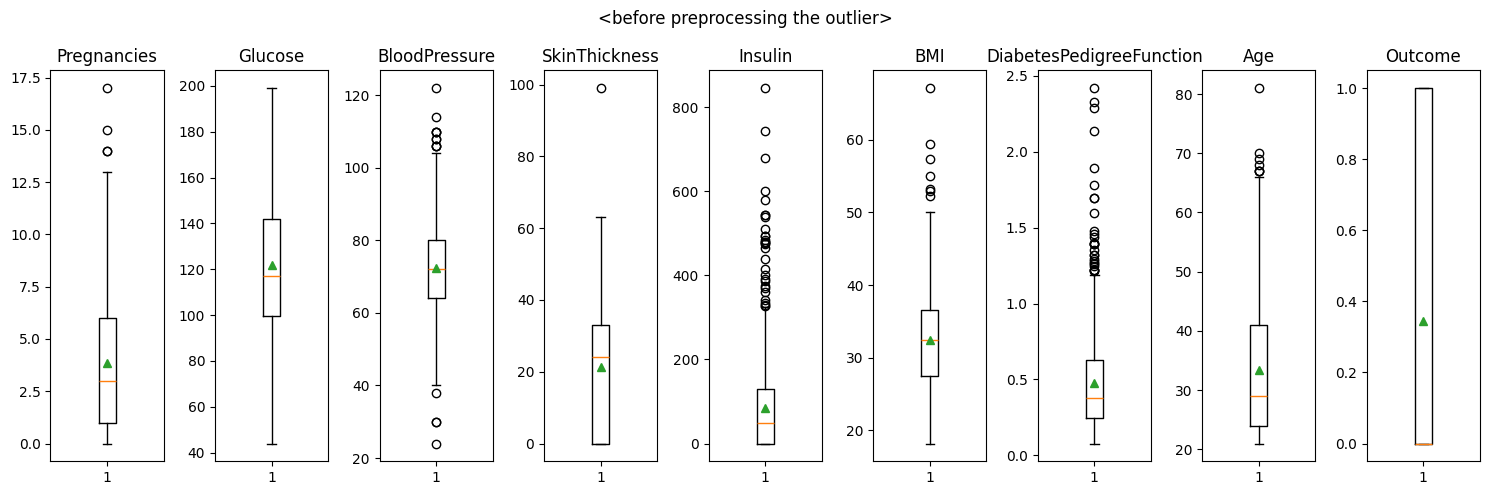

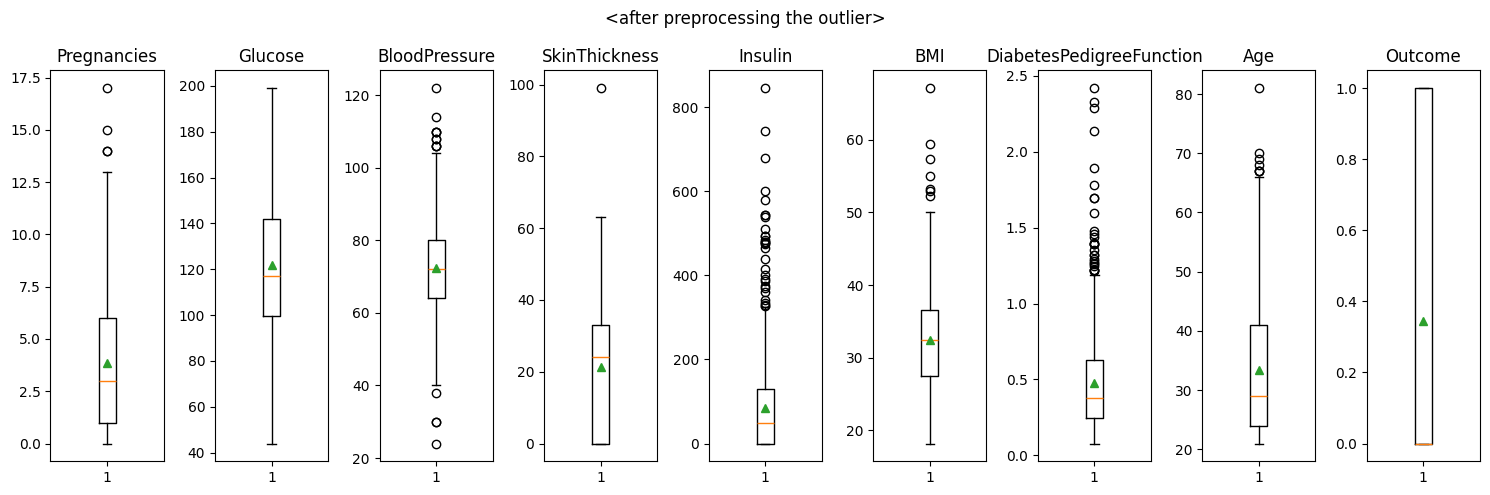

In [11]:
# subplot 시각화 및 outlier 전처리

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

fig.suptitle("<before preprocessing the outlier>")
plt.tight_layout()
plt.show()

#############

# outlier 제거 및 다시 boxplot 시각화

df = df[(df['BMI'] != 0) & (df['Glucose'] != 0) & (df['BloodPressure'] != 0)] 
# 특정 feature가 0이 되는 지점이 결측치가 된다

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

fig.suptitle("<after preprocessing the outlier>")
plt.tight_layout()
plt.show()

Outcome
0    475
1    249
Name: count, dtype: int64

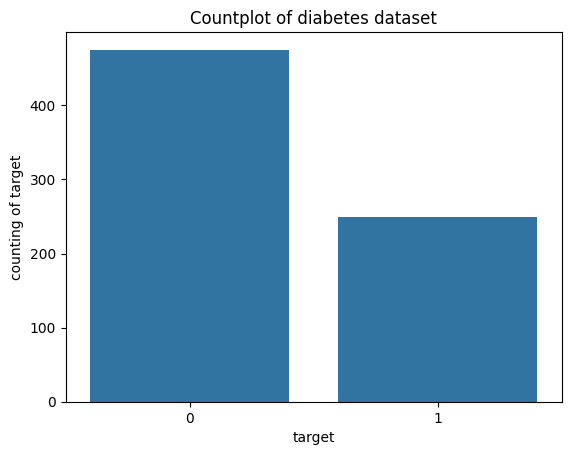

In [13]:
# target 별 counting

sns.countplot(data = df, x="Outcome")
plt.xlabel('target')
plt.ylabel("counting of target")
plt.title('Countplot of diabetes dataset')

df['Outcome'].value_counts()

In [14]:
'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'Outcome', max_size=1000)
print (df_resampled['Outcome'].value_counts())

Outcome
1    1000
0    1000
Name: count, dtype: int64


In [15]:
def add_noise(data: pd.DataFrame, noise_level: float) -> pd.DataFrame :
                      noisy_data = data.copy()
                      feature_columns = noisy_data.columns.difference(['Outcome'])  
                      noise = np.random.normal(loc=0, scale=noise_level, size=noisy_data[feature_columns].shape)
                      noisy_data[feature_columns] += noise
                      return noisy_data

In [16]:
# def mixup_data(data: pd.DataFrame, alpha: float) -> pd.DataFrame :
#                                                           feature_columns = data.columns.difference(['Outcome'])  
#                                                           num_samples = len(data)

#                                                           lambdas = np.random.beta(alpha, alpha, size=num_samples)
#                                                           mixed_data = data.copy()

#                                                           for i in range(num_samples):
#                                                               # 랜덤하게 섞기
#                                                               j = np.random.choice(num_samples)

#                                                               # feature 섞기
#                                                               mixed_data.loc[i, feature_columns] = lambdas[i] * data.loc[i, feature_columns] + (1 - lambdas[i]) * data.loc[j, feature_columns]

#                                                               # target 섞기 
#                                                               mixed_data.loc[i, 'Outcome'] = lambdas[i] * data.loc[i, 'Outcome'] + (1 - lambdas[i]) * data.loc[j, 'Outcome']

#                                                           return mixed_data


def mixup_data_binary(data: pd.DataFrame, alpha: float) -> pd.DataFrame : 
    feature_columns = data.columns.difference(['Outcome']) 
    num_samples = len(data)
    
    lambdas = np.random.beta(alpha, alpha, size=num_samples)
    mixed_data = data.copy()
    
    for i in range(num_samples) :
        # 랜덤하게 다른 샘플 선택
        j = np.random.choice(num_samples)
        
        # 특성 섞기
        mixed_data.loc[i, feature_columns] = lambdas[i] * data.loc[i, feature_columns] + (1 - lambdas[i]) * data.loc[j, feature_columns]
        
        # 타겟 섞기 및 0 또는 1로 "반올림"
        mixed_data.loc[i, 'Outcome'] = round(lambdas[i] * data.loc[i, 'Outcome'] + (1 - lambdas[i]) * data.loc[j, 'Outcome'])
    
    return mixed_data


In [17]:
# 노이즈 추가
noisy_data = add_noise(df_resampled, noise_level=0.2)

# Mixup 적용
augmented_data = mixup_data_binary(noisy_data, alpha=0.2)

# df_augmented
df_augmented = augmented_data

print ("after augmentation : ", df_augmented.shape)
df_augmented.head()

after augmentation :  (2000, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.838878,106.055374,60.300007,23.796961,1.158005,26.559657,0.156806,29.252367,1
1,6.129888,124.271957,75.599127,0.418151,6.185466,33.721577,0.137907,53.581285,1
2,5.856130,123.014115,72.047961,44.739554,230.068238,33.581391,0.798171,33.942683,0
3,11.026241,135.994075,83.883790,35.332805,129.951603,28.433796,0.552125,41.952519,1
4,8.384314,112.371498,79.638732,21.423605,183.350509,32.689179,0.351924,35.299506,1


In [18]:
# split the input, target

diabetes_input = df_augmented.drop(columns=['Outcome'])
diabetes_target = df_augmented['Outcome']

print (diabetes_input.head())
print ('\n')
print (diabetes_target.head())

   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0     6.838878  106.055374      60.300007      23.796961    1.158005   
1     6.129888  124.271957      75.599127       0.418151    6.185466   
2     5.856130  123.014115      72.047961      44.739554  230.068238   
3    11.026241  135.994075      83.883790      35.332805  129.951603   
4     8.384314  112.371498      79.638732      21.423605  183.350509   

         BMI  DiabetesPedigreeFunction        Age  
0  26.559657                  0.156806  29.252367  
1  33.721577                  0.137907  53.581285  
2  33.581391                  0.798171  33.942683  
3  28.433796                  0.552125  41.952519  
4  32.689179                  0.351924  35.299506  


0    1
1    1
2    0
3    1
4    1
Name: Outcome, dtype: int64


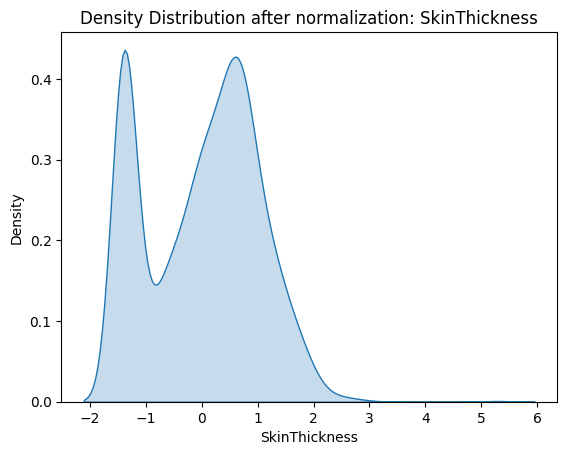

In [20]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

features = df_augmented.columns[:-1]  # 'Outcome' 제외

normalizer = StandardScaler()
diabetes_input_scaled = pd.DataFrame(normalizer.fit_transform(diabetes_input), 
                              columns=features)  

# 예시로, SkinThickness를 시각화하여 normalization이 잘 되었는지 확인해보기
sns.kdeplot(diabetes_input_scaled['SkinThickness'], fill=True)
plt.title(f'Density Distribution after normalization: SkinThickness')
plt.xlabel('SkinThickness')
plt.ylabel('Density')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes_input_scaled,
                                                    diabetes_target,
                                                    stratify=diabetes_target,
                                                    test_size = 0.3) 

X_train.shape, y_train.shape 

((1400, 8), (1400,))

In [22]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [23]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

print ("before : ", train_set.shape, test_set.shape)

X_train_seq, y_train_seq = split_sequences(train_set, 4) # 4개씩 묶기
print (X_train_seq)
print (y_train_seq)

print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 4)
print (X_test_seq)
print (y_test_seq)

print ("test : ", X_test_seq.shape, y_test_seq.shape)

before :  (1400, 9) (600, 9)
[[[-6.11717027e-01  1.03694833e+00  1.34706581e+00 ... -5.84445204e-04
    1.30290744e+00  1.58673606e+00]
  [-1.15065348e+00  7.94426238e-01  1.20296902e-01 ...  2.11695830e+00
    3.66451833e-01 -7.33585137e-01]
  [-2.04827843e-01 -1.34576404e+00  9.87165596e-01 ... -5.89443235e-01
   -1.58227417e+00 -4.74087676e-02]
  [ 9.63555193e-01 -4.86924910e-01 -6.14121604e-01 ... -7.58490293e-02
   -9.99003284e-01  6.67966609e-01]]

 [[-1.15065348e+00  7.94426238e-01  1.20296902e-01 ...  2.11695830e+00
    3.66451833e-01 -7.33585137e-01]
  [-2.04827843e-01 -1.34576404e+00  9.87165596e-01 ... -5.89443235e-01
   -1.58227417e+00 -4.74087676e-02]
  [ 9.63555193e-01 -4.86924910e-01 -6.14121604e-01 ... -7.58490293e-02
   -9.99003284e-01  6.67966609e-01]
  [-2.27137703e-01 -9.41072438e-01  6.79415953e-01 ... -5.69365009e-01
    2.28044316e-01 -3.71188496e-01]]

 [[-2.04827843e-01 -1.34576404e+00  9.87165596e-01 ... -5.89443235e-01
   -1.58227417e+00 -4.74087676e-02]
  [ 

In [24]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_seq_encoded = to_categorical(y_train_seq)
y_test_seq_encoded = to_categorical(y_test_seq)

print(y_train_seq[:5])  
print(y_train_seq_encoded[:5]) 

print(y_test_seq[:5])  
print(y_test_seq_encoded[:5]) 

[1. 1. 0. 1. 1.]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[0. 0. 0. 0. 0.]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


-----

### 2. 1D-CNN modeling 구성
- 

In [ ]:
# modeling

from tensorflow.keras import regularizers

input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(input_layer)
batch_1 = keras.layers.BatchNormalization()(conv_1)
pooling_1 = keras.layers.MaxPooling1D(2, padding='same')(batch_1)
dropout_1 = keras.layers.Dropout(0.2)(pooling_1)

# 두 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(dropout_1)
batch_2 = keras.layers.BatchNormalization()(conv_2)
pooling_2 = keras.layers.MaxPooling1D(2, padding='same')(batch_2)
dropout_2 = keras.layers.Dropout(0.2)(pooling_2)

# flatten 대신에 pooling1D를 사용해봄
global_pool = keras.layers.GlobalAveragePooling1D()(dropout_2)

'''
    계속적으로 val_loss가 늘어나는 현상 발견
    regularizer를 추가하여 l2 규제를 하게끔 함
    l1 규제 : 절댓값 규제 (특정 feature을 0으로 만들 수 있음)
    l2 규제 : 제곱 규제 (특정 feature을 0과 가깝게 만들 수 있음)
'''

# Dense 레이어
dense_1 = keras.layers.Dense(16, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(global_pool)
dense_2 = keras.layers.Dense(8, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(dense_1)

output_layer = keras.layers.Dense(len(set(y_train.tolist())), activation='sigmoid')(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)